In [199]:
import autograd.numpy as np
from autograd import grad, elementwise_grad
import autograd.numpy.random as npr
from autograd.misc.optimizers import adam

In [200]:
x0 = 0
x1 = 1

def init_random_params(scale, layer_sizes, rs=npr.RandomState(42)):
    return [(rs.randn(insize, outsize) * scale,   # weight matrix
             rs.randn(outsize) * scale)           # bias vector
            for insize, outsize in zip(layer_sizes[:-1], layer_sizes[1:])]

def tanh(x):
    return (2 / (1.0 + np.exp(-2*x))) - 1

def psi(nnparams, inputs):
    origInput = inputs
    xTilde = (origInput - x0) / (x1 - x0)
    
    for W, b in nnparams:
        outputs = np.dot(inputs, W) + b
        inputs = tanh(outputs)    
        
    return (1-np.exp(xTilde * (1 - xTilde))) * outputs

dpsi = elementwise_grad(psi, 1) # dpsi/dx 
ddpsi = elementwise_grad(dpsi, 1) # d^2psi/dx^2

In [201]:
nnparams = init_random_params(0.1, layer_sizes=[1, 32, 1])
params = {'nn': nnparams, 'E': 5.0}

x = np.linspace(0, 1, 200)[:, None]

def objective(params, step):
    nnparams = params['nn']
    E = params['E']        
    
    wave = psi(nnparams,x)
    zeq = -0.5 * ddpsi(nnparams, x)  - E*wave
    y2 = wave**2
    
    # This is a numerical trapezoid integration
    prob = np.sum((y2[1:] + y2[0:-1]) / 2 * (x[1:] - x[0:-1]))
    
    return np.mean(zeq**2) + (1.0 - prob)**2

def objectiveDebug (params, step) :
    nnparams = params['nn']
    E = params['E']        
    # This is Schrodinger's eqn
    zeq = -0.5 * ddpsi(nnparams, x)  - E*psi(nnparams, x) 
    y2 = psi(nnparams, x)**2
    # This is a numerical trapezoid integration
    prob = np.sum((y2[1:] + y2[0:-1]) / 2 * (x[1:] - x[0:-1]))
    mean = np.mean(zeq**2)
    
    print ("Iteration " + str(step) + " diffeq = " + str(mean) + " prob = " + str(prob))
    print ("loss = " + str(mean + (1-prob)**2) + " E = " + str(params['E']))
    print ("---------------------------------")
    

# This gives us feedback from the optimizer
def callback(params, step, g):
    if step % 100 == 0:
        #print("Iteration {0:3d} objective {1}".format(step,
                                                      #objective(params, step))
        objectiveDebug (params, step)

In [202]:
params = adam(grad(objective), params,
              step_size=0.001, num_iters=5001, callback=callback) 

print(params['E'])

Iteration 0 diffeq = 0.0008514358167780347 prob = 0.00019038908060879352
loss = 1.0004706939035626 E = 5.0
---------------------------------
Iteration 100 diffeq = 0.05307764116465604 prob = 0.052950743375310555
loss = 0.949979935638033 E = 4.948436511478132
---------------------------------
Iteration 200 diffeq = 0.428473274848307 prob = 0.6151206200464333
loss = 0.576605411961749 E = 4.943541976468618
---------------------------------
Iteration 300 diffeq = 0.24790211896253267 prob = 0.810614635401876
loss = 0.28376893528649705 E = 4.938439486549481
---------------------------------
Iteration 400 diffeq = 0.062104316720263154 prob = 0.9404006916564267
loss = 0.06565639427529547 E = 4.935441465553876
---------------------------------
Iteration 500 diffeq = 0.011057595983570064 prob = 0.9867865710634809
loss = 0.011232190687830504 E = 4.934920259091492
---------------------------------
Iteration 600 diffeq = 0.007121699558257066 prob = 0.9948721826469152
loss = 0.007147994069063663 E =

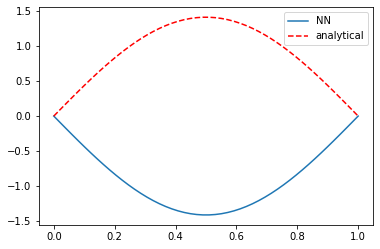

In [203]:
%matplotlib inline
import matplotlib.pyplot as plt

x = np.linspace(0, 1)[:, None]
y = psi(params['nn'], x)

plt.plot(x, y, label='NN')
plt.plot(x, np.sqrt(2) * np.sin(np.pi * x), 'r--', label='analytical')
plt.legend()